In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pysentani as sti

In [2]:
survey = pd.read_excel('../data-anonymous/sentani-merged-cleaned-anonymous-2014-11-29.xlsx')
survey['access_type'] = sti.access_type(survey)

A future electrification model will be created to provide an estimation of what appliance ownership will look like after fully operational and reliable grid systems are put into place. Anaylsis is conducted at the access type level and will be applied in future analysis at the village level.
For each appliance, responses were gathered regarding current ownership (yes/no/NaN) and desire to purchse (yes/no/NaN). Non-responses are not calculated into the model and are assumed to reflect the rest of the survey.

In [3]:
appliances = ['lighting','TV','radio','fridge','rice_cooker','fan']

In [4]:
now_columns = ['app_now/{}'.format(a) for a in appliances]
buy_columns = ['app_buy/{}'.format(a) for a in appliances]
app_now = survey[now_columns]
app_buy = survey[buy_columns]

There are 4 possible response patterns which provide specific information necessary for the model calculation. (0,0) (0,1) (1,0) are straightforward, while (1,1) is not. If a household indicates that they own an appliance and also want to purchase the same appliance, we can treat that pattern 2 ways: (1,1) = 1 or (1,1) = 0. The unknown is whether they would buy the appliance if they had reliable and constant electricity or if they had enough money to pay for it. The calculation will reflect the former which is a desired end result of the study and if successful, might have a profound effect on the latter which lends support to the (1,1) = 1 calculation.

|Currently Owned|Want To Buy|Calculation|
|---------------|-----------|-----------|
|0              |0          |0          |
|0              |1          |1          |

If fully electrified and financially capable:

|Currently Owned|Want To Buy|Calculation|
|---------------|-----------|-----------|
|1              |0          |0          |
|1              |1          |1          |

If fully electrified and financially uncapable:
(We will not use this model because we want to plan for a grid that allows the possibility of financial growth)

|Currently Owned|Want To Buy|Calculation|
|---------------|-----------|-----------|
|1              |0          |0          |
|1              |1          |0          |

In [5]:
def willing_to_buy(row, now=None, buy=None):
    if row[now]==1:
        return 0
    if row[now]==0 and row[buy]==0:
        return 0
    if row[now]==0 and row[buy]==1:
        return 1

def calc_willingness(survey, appliance):
    app_now_appliance = 'app_now/' + appliance
    app_buy_appliance = 'app_buy/' + appliance
    survey['wb/' + appliance] = survey.apply(willing_to_buy, 
                                axis=1, 
                                now=app_now_appliance,
                                buy=app_buy_appliance)

# Creating variable with for loop adding each from appliance_list to calc_willingess function
WBlist = []
for appliance in appliances:
    calc_willingness(survey, appliance)
    WBlist.append('wb/' + appliance)

In [6]:
will_buy_columns = ['wb/{}'.format(a) for a in appliances]
app_will_buy = survey[will_buy_columns]

In [7]:
app_now.columns = [col.replace('app_now/', '') for col in app_now.columns]
app_buy.columns = [col.replace('app_buy/', '') for col in app_buy.columns]
app_will_buy.columns = [col.replace('wb/', '') for col in app_will_buy.columns]

`future_electfication` takes the sum of current ownership mean and our calculated will buy mean to provide a view of what appliance ownership will look like after all appliance acquisitions are fulfilled.

In [8]:
app_now_mean = app_now.groupby(survey['access_type']).mean().stack()
app_buy_mean = app_will_buy.groupby(survey['access_type']).mean().stack()

future_electrification = app_buy_mean + app_now_mean 
fe_tidy = future_electrification.reset_index()
fe_tidy.rename(columns={'level_1':'Appliance', 0:'Percent Ownership'},
              inplace=True)
fe_tidy.head()

,access_type,Appliance,Percent Ownership
0,PLN_grid,lighting,0.938494
1,PLN_grid,TV,0.926658
2,PLN_grid,radio,0.346609
3,PLN_grid,fridge,0.768972
4,PLN_grid,rice_cooker,0.478144


In [9]:
fe_tidy.replace(to_replace = {'access_type': {'PLN_grid': 'PLN Grid',
                                              'community_microgrid': 'Community Microgrid',
                                              'PLN_microgrid': 'PLN Microgrid',
                                              'no_access': 'No Access'}},inplace = True)
fe_tidy.replace(to_replace= {'Appliance': {'lighting':'Lighting',
                                           'radio':'Radio',
                                           'fridge':'Fridge',
                                           'rice_cooker':'Rice Cooker',
                                           'fan':'Fan'}}, inplace=True)

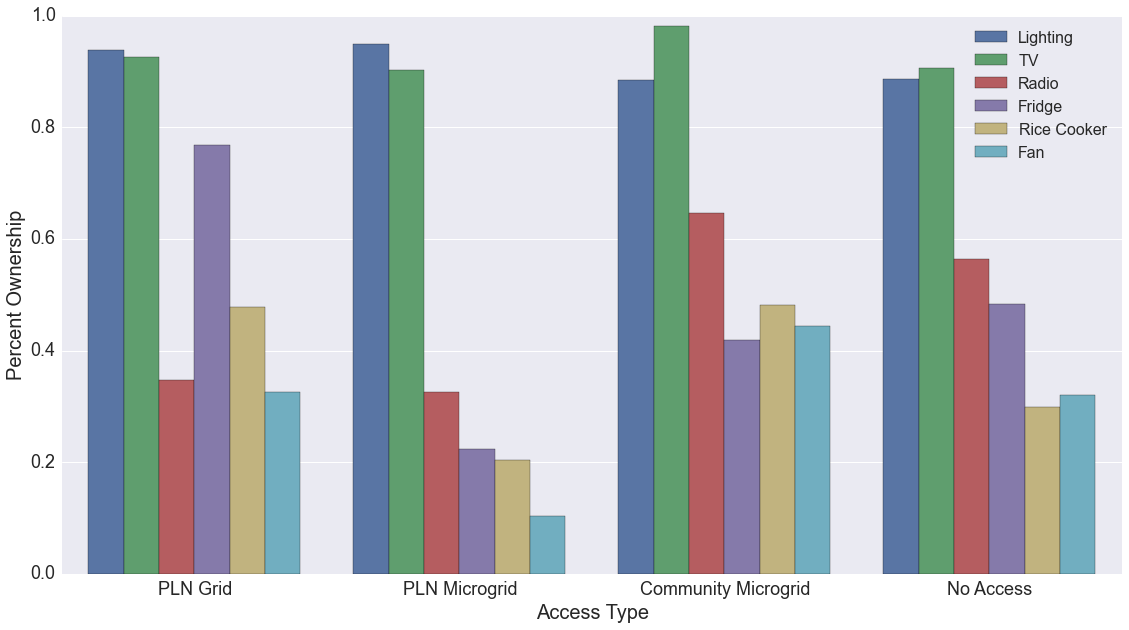

In [10]:
plt.figure(figsize=(19,10))
sns.barplot(hue='Appliance', y='Percent Ownership', x='access_type', data=fe_tidy)
plt.ylabel('Percent Ownership', fontsize=20)
plt.xlabel('Access Type', fontsize=20)
plt.legend(prop={'size':16})
plt.tick_params(labelsize=18)
plt.savefig('post-electrification-ownership.pdf')